In [1]:
import sys
from pathlib import Path

# ベースラインモデルとして、時系列順に8:2で分割して学習データと検証データを作成し、勾配ブースティング木モデルのスコアを記録する
# プロジェクトルートのパスを通す
sys.path.append(str(Path.cwd().parent))

/Users/kokiyamaguchi/Documents/projects/competitions/stock-prediction-practice/src/visualize.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=target, y=feature, data=df, palette="Set2", cut=0)


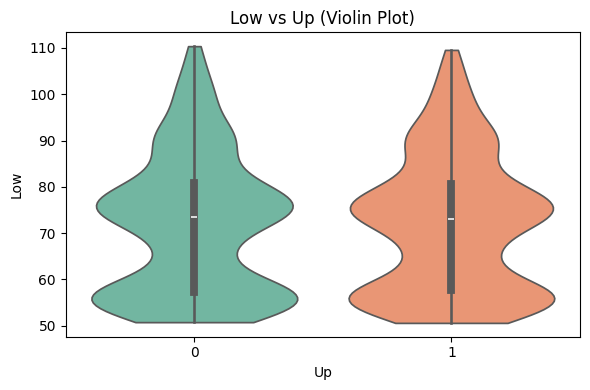

,Open,High,Low,Close,Up,dayofweek,Open_lag_1,Open_diff_1,Open_lag_2,Open_diff_2,...,close_max_5,close_min_5,close_range_5,close_ma_10,close_std_10,close_max_10,close_min_10,close_range_10,close_up,streak
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-15,51.01,51.27,50.70,51.01,1,3,50.43,0.58,50.90,0.11,...,51.01,50.61,0.40,50.959,0.291641,51.51,50.61,0.90,1,2
2004-01-16,50.97,51.16,50.89,51.13,1,4,51.01,-0.04,50.43,0.54,...,51.13,50.61,0.52,51.000,0.283000,51.51,50.61,0.90,1,3
2004-01-20,51.40,51.46,51.04,51.21,0,1,50.97,0.43,51.01,0.39,...,51.21,50.61,0.60,51.042,0.279515,51.51,50.61,0.90,1,4
2004-01-21,50.94,51.18,50.86,51.10,1,2,51.40,-0.46,50.97,-0.03,...,51.21,50.64,0.57,51.037,0.277811,51.51,50.61,0.90,0,-1
2004-01-22,51.19,51.41,51.14,51.20,0,3,50.94,0.25,51.40,-0.21,...,51.21,51.01,0.20,51.006,0.232818,51.28,50.61,0.67,1,1


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from src.features.feature_engineering import create_features
from src.utils.env import EnvConfig
from src.visualize import plot_violin


config = EnvConfig()
train_data_path = config.abs_input_dir / 'train.csv'
test_data_path = config.abs_input_dir / 'test.csv'

df_raw = pd.read_csv(train_data_path)
df_feat = create_features(df_raw)
plot_violin(df_feat, "Low")

df_feat.head()



In [5]:

from src.models.model_xgb import ModelXGB
from src.metrics import classification_metrics
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

X = df_feat.drop(columns=['Up'])
y = df_feat['Up']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
from sklearn.feature_selection import mutual_info_classif

# 相互情報量を計算
mi = mutual_info_classif(X, y, discrete_features=False)
mi_df = pd.DataFrame({
    "feature": X.columns,
    "mutual_info": mi
}).sort_values("mutual_info", ascending=False)

print(mi_df.head(10))


if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()


# ========= Hydra config 読み込み ========= #
initialize(config_path="../configs", version_base="1.3")
cfg = compose(config_name="config")
print("\u2705 Loaded config:\n", OmegaConf.to_yaml(cfg))

params = dict(cfg.model)
num_round = params.pop('num_round')
early_stopping_rounds = params.pop('early_stopping_rounds')

model = ModelXGB(run_fold_name='xgb_baseline', params={
    **params,
    "early_stopping_rounds": early_stopping_rounds,
    "num_round": num_round
})
model.train(X_train, y_train, X_val, y_val)

metrics_df = classification_metrics(model, X_val, y_val)
print(metrics_df)



         feature  mutual_info
6    Open_diff_1     0.042107
2            Low     0.026721
8    Open_diff_2     0.025104
16   High_diff_3     0.021303
18    Low_diff_1     0.020385
27   Close_lag_3     0.019972
43  close_std_10     0.019483
26  Close_diff_2     0.017923
12   High_diff_1     0.013846
34   close_max_3     0.010954
✅ Loaded config:
 model:
  name: xgb
  objective: binary:logistic
  eval_metric: logloss
  eta: 0.1
  max_depth: 3
  subsample: 0.8
  colsample_bytree: 0.8
  early_stopping_rounds: 50
  num_round: 1000
seed: 42
target_col: Up

   Accuracy  Precision    Recall        F1
0  0.626238   0.690476  0.539535  0.605744


/Users/kokiyamaguchi/Documents/projects/competitions/stock-prediction-practice/.venv/lib/python3.13/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/Users/kokiyamaguchi/Documents/projects/competitions/stock-prediction-practice/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [21:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "name" } are not used.

  self.starting_round = model.num_boosted_rounds()
